In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import scipy as sp
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer

In [2]:

import neurokit2 as nk  # Load the package

simulated_ecg = nk.ecg_simulate(duration=8, sampling_rate=200, heart_rate=80)

nk.signal_plot(simulated_ecg, sampling_rate=200)

In [3]:
simulated_ecg

array([ 1.08387236,  0.99244589,  0.76446361, ..., -0.10225384,
       -0.10080577, -0.09915184])

In [4]:
simulated_ecg=pd.DataFrame(simulated_ecg)
simulated_ecg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1600 non-null   float64
dtypes: float64(1)
memory usage: 12.6 KB


In [5]:
ecg_sig= nk.ecg_simulate(duration=8, sampling_rate=200, heart_rate=80)
ecg_peaks=nk.ecg_findpeaks(ecg_sig)
print(ecg_peaks)

{'ECG_R_Peaks': array([1346])}


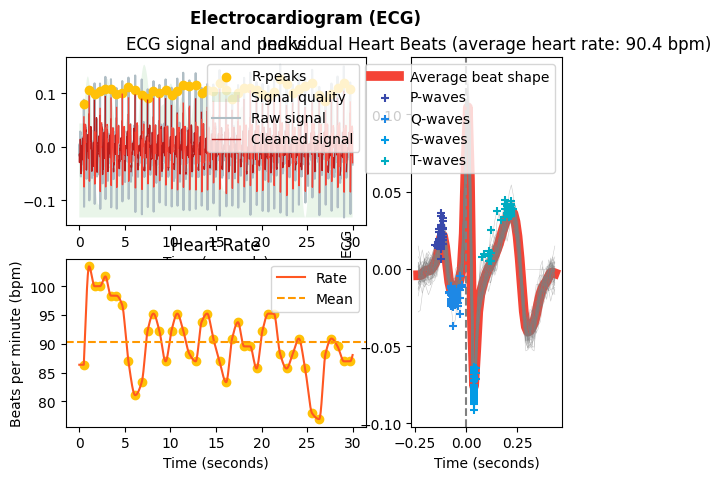

In [6]:
data = nk.data("bio_resting_5min_100hz")
ecg_signals, info = nk.ecg_process(data["ECG"], sampling_rate=100)

nk.ecg_plot(ecg_signals[:3000], info)

In [7]:
ecg_inter=nk.ecg_intervalrelated(ecg_signals)

In [8]:
ecg_inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 92 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ECG_Rate_Mean                 1 non-null      object
 1   HRV_MeanNN                    1 non-null      object
 2   HRV_SDNN                      1 non-null      object
 3   HRV_SDANN1                    1 non-null      object
 4   HRV_SDNNI1                    1 non-null      object
 5   HRV_SDANN2                    1 non-null      object
 6   HRV_SDNNI2                    1 non-null      object
 7   HRV_SDANN5                    1 non-null      object
 8   HRV_SDNNI5                    1 non-null      object
 9   HRV_RMSSD                     1 non-null      object
 10  HRV_SDSD                      1 non-null      object
 11  HRV_CVNN                      1 non-null      object
 12  HRV_CVSD                      1 non-null      object
 13  HRV_MedianNN            

In [9]:

# Simulate ECG signal with PVCs
ecg_signal_pvc = nk.ecg_simulate(duration=8, heart_rate=80, rhythm='sinus', pvc_rate=0.1)

# Plot the simulated ECG signal with PVCs
nk.signal_plot(ecg_signal_pvc)


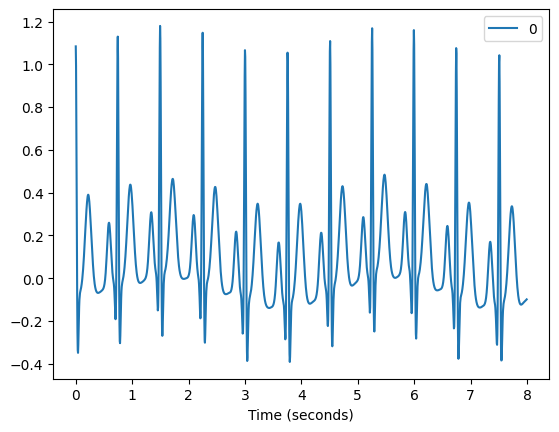

In [10]:
nk.signal_plot(simulated_ecg, sampling_rate=200)

In [11]:
import neurokit2 as nk
import matplotlib.pyplot as plt

# Function to generate live ECG signal
def generate_live_ecg(duration=10, heart_rate=60):
    return nk.ecg_simulate(duration=duration, heart_rate=heart_rate)

# Function to process live ECG signal
def process_ecg_signal(ecg_signal):
    # Example processing: Plot the ECG signal
    plt.plot(ecg_signal)
    plt.xlabel('Time')
    plt.ylabel('ECG Signal')
    plt.title('Live ECG Signal')
    plt.show()

# Main function
def main():
    # Generate live ECG signal
    ecg_signal = generate_live_ecg(duration=10, heart_rate=60)
    
    # Process live ECG signal
    process_ecg_signal(ecg_signal)

# Run the program
if __name__ == "__main__":
    main()


In [12]:
# -*- coding: utf-8 -*-
"""Script for formatting the MIT-Arrhythmia database

Steps:
    1. Download the ZIP database from https://alpha.physionet.org/content/mitdb/1.0.0/
    2. Open it with a zip-opener (WinZip, 7zip).
    3. Extract the folder of the same name (named 'mit-bih-arrhythmia-database-1.0.0') to the same folder as this script.
    4. Run this script.

Credits:
    https://github.com/berndporr/py-ecg-detectors/blob/master/tester_MITDB.py by Bernd Porr
"""
import pandas as pd
import numpy as np
import wfdb
import os
import neurokit2 as nk

database_path = "./mit-bih-arrhythmia-database-1.0.0/"

# Check if expected folder exists
if not os.path.exists(database_path):
    url = "https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
    download_successful = nk.download_zip(url, database_path)
    if not download_successful:
        raise ValueError(
            "NeuroKit error: download of MIT-Arrhythmia database failed. "
            "Please download it manually from https://alpha.physionet.org/content/mitdb/1.0.0/ "
            "and unzip it in the same folder as this script."
        )

data_files = [database_path + file for file in os.listdir(database_path) if ".dat" in file]

def read_file(file, participant):
    """Utility function
    """
    # Get signal
    data = pd.DataFrame({"ECG": wfdb.rdsamp(file[:-4])[0][:, 0]})
    data["Participant"] = "MIT-Arrhythmia_%.2i" %(participant)
    data["Sample"] = range(len(data))
    data["Sampling_Rate"] = 360
    data["Database"] = "MIT-Arrhythmia-x" if "x_mitdb" in file else "MIT-Arrhythmia"

    # getting annotations
    anno = wfdb.rdann(file[:-4], 'atr')
    anno = np.unique(anno.sample[np.in1d(anno.symbol, ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?'])])
    anno = pd.DataFrame({"Rpeaks": anno})
    anno["Participant"] = "MIT-Arrhythmia_%.2i" %(participant)
    anno["Sampling_Rate"] = 360
    anno["Database"] = "MIT-Arrhythmia-x" if "x_mitdb" in file else "MIT-Arrhythmia"

    return data, anno




dfs_ecg = []
dfs_rpeaks = []

for participant, file in enumerate(data_files):

    print("Participant: " + str(participant + 1) + "/" + str(len(data_files)))

    data, anno = read_file(file, participant)

    # Store with the rest
    dfs_ecg.append(data)
    dfs_rpeaks.append(anno)

    # Store additional recording if available
    if "x_" + file.replace(database_path, "") in os.listdir(database_path + "x_mitdb/"):
        print("  - Additional recording detected.")
        data, anno = read_file(database_path + "/x_mitdb/" + "x_" + file.replace(database_path, ""), participant)
        # Store with the rest
        dfs_ecg.append(data)
        dfs_rpeaks.append(anno)



# Save
df_ecg = pd.concat(dfs_ecg).to_csv("ECGs.csv", index=False)
dfs_rpeaks = pd.concat(dfs_rpeaks).to_csv("Rpeaks.csv", index=False)

# Quick test
import neurokit2 as nk
nk.events_plot(anno["Rpeaks"][anno["Rpeaks"] <= 1000], data["ECG"][0:1002])

Participant: 1/48
Participant: 2/48
Participant: 3/48
Participant: 4/48
Participant: 5/48
Participant: 6/48
Participant: 7/48
Participant: 8/48
Participant: 9/48
  - Additional recording detected.
Participant: 10/48
  - Additional recording detected.
Participant: 11/48
  - Additional recording detected.
Participant: 12/48
  - Additional recording detected.
Participant: 13/48
  - Additional recording detected.
Participant: 14/48
  - Additional recording detected.
Participant: 15/48
  - Additional recording detected.
Participant: 16/48
  - Additional recording detected.
Participant: 17/48
  - Additional recording detected.
Participant: 18/48
Participant: 19/48
Participant: 20/48
  - Additional recording detected.
Participant: 21/48
  - Additional recording detected.
Participant: 22/48
  - Additional recording detected.
Participant: 23/48
  - Additional recording detected.
Participant: 24/48
Participant: 25/48
Participant: 26/48
Participant: 27/48
Participant: 28/48
Participant: 29/48
Par

In [13]:
df_ecg=pd.read_csv('ECGs.csv')

In [14]:
df_ecg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168000 entries, 0 to 36167999
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ECG            float64
 1   Participant    object 
 2   Sample         int64  
 3   Sampling_Rate  int64  
 4   Database       object 
dtypes: float64(1), int64(2), object(2)
memory usage: 1.3+ GB


In [15]:
df_ecg.head()

ECG        Participant  Sample  Sampling_Rate        Database
0 -0.145  MIT-Arrhythmia_00       0            360  MIT-Arrhythmia
1 -0.145  MIT-Arrhythmia_00       1            360  MIT-Arrhythmia
2 -0.145  MIT-Arrhythmia_00       2            360  MIT-Arrhythmia
3 -0.145  MIT-Arrhythmia_00       3            360  MIT-Arrhythmia
4 -0.145  MIT-Arrhythmia_00       4            360  MIT-Arrhythmia

In [16]:
df_rpeaks=pd.read_csv('Rpeaks.csv')

In [17]:
df_rpeaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125596 entries, 0 to 125595
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Rpeaks         125596 non-null  int64 
 1   Participant    125596 non-null  object
 2   Sampling_Rate  125596 non-null  int64 
 3   Database       125596 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.8+ MB


In [18]:
df_rpeaks.head()

Rpeaks        Participant  Sampling_Rate        Database
0      77  MIT-Arrhythmia_00            360  MIT-Arrhythmia
1     370  MIT-Arrhythmia_00            360  MIT-Arrhythmia
2     662  MIT-Arrhythmia_00            360  MIT-Arrhythmia
3     946  MIT-Arrhythmia_00            360  MIT-Arrhythmia
4    1231  MIT-Arrhythmia_00            360  MIT-Arrhythmia

In [19]:
partis=df_rpeaks['Participant'].unique()
print(partis)

['MIT-Arrhythmia_00' 'MIT-Arrhythmia_01' 'MIT-Arrhythmia_02'
 'MIT-Arrhythmia_03' 'MIT-Arrhythmia_04' 'MIT-Arrhythmia_05'
 'MIT-Arrhythmia_06' 'MIT-Arrhythmia_07' 'MIT-Arrhythmia_08'
 'MIT-Arrhythmia_09' 'MIT-Arrhythmia_10' 'MIT-Arrhythmia_11'
 'MIT-Arrhythmia_12' 'MIT-Arrhythmia_13' 'MIT-Arrhythmia_14'
 'MIT-Arrhythmia_15' 'MIT-Arrhythmia_16' 'MIT-Arrhythmia_17'
 'MIT-Arrhythmia_18' 'MIT-Arrhythmia_19' 'MIT-Arrhythmia_20'
 'MIT-Arrhythmia_21' 'MIT-Arrhythmia_22' 'MIT-Arrhythmia_23'
 'MIT-Arrhythmia_24' 'MIT-Arrhythmia_25' 'MIT-Arrhythmia_26'
 'MIT-Arrhythmia_27' 'MIT-Arrhythmia_28' 'MIT-Arrhythmia_29'
 'MIT-Arrhythmia_30' 'MIT-Arrhythmia_31' 'MIT-Arrhythmia_32'
 'MIT-Arrhythmia_33' 'MIT-Arrhythmia_34' 'MIT-Arrhythmia_35'
 'MIT-Arrhythmia_36' 'MIT-Arrhythmia_37' 'MIT-Arrhythmia_38'
 'MIT-Arrhythmia_39' 'MIT-Arrhythmia_40' 'MIT-Arrhythmia_41'
 'MIT-Arrhythmia_42' 'MIT-Arrhythmia_43' 'MIT-Arrhythmia_44'
 'MIT-Arrhythmia_45' 'MIT-Arrhythmia_46' 'MIT-Arrhythmia_47']


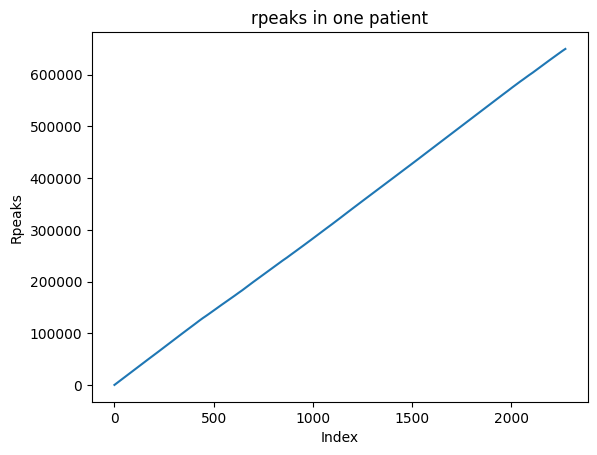

In [20]:
import matplotlib.pyplot as plt
rpeaks00=df_rpeaks.loc[df_rpeaks['Participant']=='MIT-Arrhythmia_00','Rpeaks']
plt.plot(rpeaks00)
plt.xlabel('Index')
plt.ylabel('Rpeaks')
plt.title('rpeaks in one patient')
plt.show()

In [21]:
partis=df_ecg['Participant'].unique()
print(partis)

['MIT-Arrhythmia_00' 'MIT-Arrhythmia_01' 'MIT-Arrhythmia_02'
 'MIT-Arrhythmia_03' 'MIT-Arrhythmia_04' 'MIT-Arrhythmia_05'
 'MIT-Arrhythmia_06' 'MIT-Arrhythmia_07' 'MIT-Arrhythmia_08'
 'MIT-Arrhythmia_09' 'MIT-Arrhythmia_10' 'MIT-Arrhythmia_11'
 'MIT-Arrhythmia_12' 'MIT-Arrhythmia_13' 'MIT-Arrhythmia_14'
 'MIT-Arrhythmia_15' 'MIT-Arrhythmia_16' 'MIT-Arrhythmia_17'
 'MIT-Arrhythmia_18' 'MIT-Arrhythmia_19' 'MIT-Arrhythmia_20'
 'MIT-Arrhythmia_21' 'MIT-Arrhythmia_22' 'MIT-Arrhythmia_23'
 'MIT-Arrhythmia_24' 'MIT-Arrhythmia_25' 'MIT-Arrhythmia_26'
 'MIT-Arrhythmia_27' 'MIT-Arrhythmia_28' 'MIT-Arrhythmia_29'
 'MIT-Arrhythmia_30' 'MIT-Arrhythmia_31' 'MIT-Arrhythmia_32'
 'MIT-Arrhythmia_33' 'MIT-Arrhythmia_34' 'MIT-Arrhythmia_35'
 'MIT-Arrhythmia_36' 'MIT-Arrhythmia_37' 'MIT-Arrhythmia_38'
 'MIT-Arrhythmia_39' 'MIT-Arrhythmia_40' 'MIT-Arrhythmia_41'
 'MIT-Arrhythmia_42' 'MIT-Arrhythmia_43' 'MIT-Arrhythmia_44'
 'MIT-Arrhythmia_45' 'MIT-Arrhythmia_46' 'MIT-Arrhythmia_47']


In [22]:
import matplotlib.pyplot as plt
ecg00=df_ecg.loc[df_ecg['Participant']=='MIT-Arrhythmia_00','ECG']
plt.plot(ecg00[:1000])
plt.xlabel('Index')
plt.ylabel('ECG')
plt.show()

In [23]:
print(simulated_ecg)

             0
0     1.083872
1     0.992446
2     0.764464
3     0.464725
4     0.163914
...        ...
1595 -0.104807
1596 -0.103567
1597 -0.102254
1598 -0.100806
1599 -0.099152

[1600 rows x 1 columns]


In [24]:
print(ecg00)

0        -0.145
1        -0.145
2        -0.145
3        -0.145
4        -0.145
          ...  
649995   -0.075
649996   -0.445
649997   -0.675
649998   -0.765
649999   -1.280
Name: ECG, Length: 650000, dtype: float64


In [25]:
ecg00=ecg00.tolist()

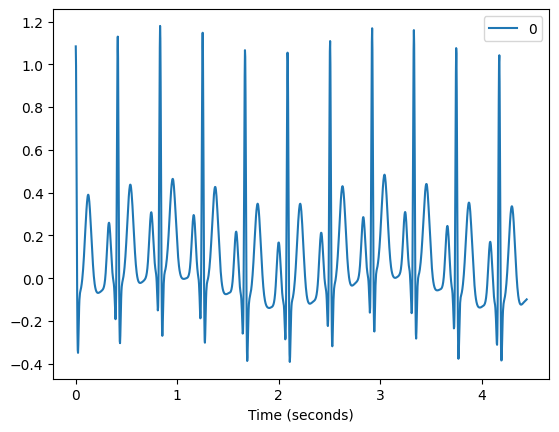

In [26]:
nk.signal_plot(simulated_ecg, sampling_rate=360)

In [27]:
ecg00,info00=nk.ecg_process(ecg00, sampling_rate=360, method='neurokit')

In [28]:
nk.ecg_plot(ecg00,info00)

In [29]:
ecg00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ECG_Raw                           650000 non-null  float64
 1   ECG_Clean                         650000 non-null  float64
 2   ECG_Rate                          650000 non-null  float64
 3   ECG_Quality                       650000 non-null  float64
 4   ECG_R_Peaks                       650000 non-null  int64  
 5   ECG_P_Peaks                       650000 non-null  int64  
 6   ECG_P_Onsets                      650000 non-null  int64  
 7   ECG_P_Offsets                     650000 non-null  int64  
 8   ECG_Q_Peaks                       650000 non-null  int64  
 9   ECG_R_Onsets                      650000 non-null  int64  
 10  ECG_R_Offsets                     650000 non-null  int64  
 11  ECG_S_Peaks                       650000 non-null  i

In [30]:
ecgseg=nk.ecg_segment(ecg00['ECG_Clean'])
print(ecgseg['1'])
print(ecgseg['2'])
print(ecgseg['3'])

             Signal  Index Label
-0.181457 -0.064647    188     1
-0.180454 -0.058951    189     1
-0.179452 -0.053357    190     1
-0.178449 -0.047356    191     1
-0.177446 -0.040745    192     1
...             ...    ...   ...
 0.332981 -0.081027    701     1
 0.333983 -0.080315    702     1
 0.334986 -0.079399    703     1
 0.335989 -0.078279    704     1
 0.336992 -0.076955    705     1

[518 rows x 3 columns]
             Signal  Index Label
-0.181457 -0.061946    764     2
-0.180454 -0.053892    765     2
-0.179452 -0.045124    766     2
-0.178449 -0.035846    767     2
-0.177446 -0.026466    768     2
...             ...    ...   ...
 0.332981 -0.076572   1277     2
 0.333983 -0.077078   1278     2
 0.334986 -0.076971   1279     2
 0.335989 -0.076661   1280     2
 0.336992 -0.075942   1281     2

[518 rows x 3 columns]
             Signal  Index Label
-0.181457 -0.090241   1333     3
-0.180454 -0.084737   1334     3
-0.179452 -0.078620   1335     3
-0.178449 -0.071381   1336  

In [31]:
sampling_rate= 360
start_time=60*25+13
end_time=60*25+16
start_index = int(start_time * sampling_rate)
end_index = int(end_time * sampling_rate)
iso_ecg=ecg00['ECG_Clean'][start_index:end_index]
nk.signal_plot(iso_ecg, sampling_rate=360)

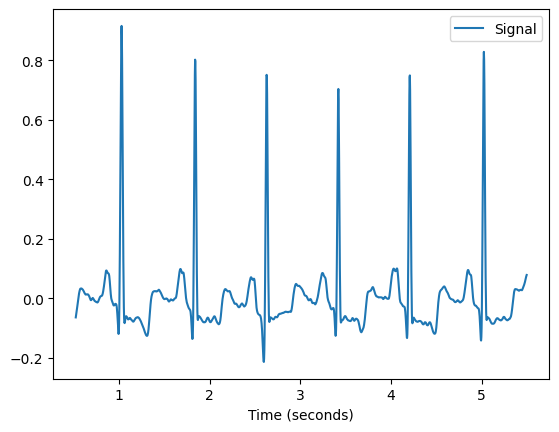

In [32]:
nk.signal_plot(ecg00['ECG_Clean'][188:5*360+180],sampling_rate=360)

In [33]:
iso_ecg=ecg00[start_index:end_index]
meansarr=iso_ecg.mean()
meansnorm=ecg00[188:5*360+180].mean()

In [34]:
print(meansarr)
print(meansnorm)

ECG_Raw                             -0.268685
ECG_Clean                            0.004873
ECG_Rate                            74.801518
ECG_Quality                          0.957319
ECG_R_Peaks                          0.003704
ECG_P_Peaks                          0.003704
ECG_P_Onsets                         0.003704
ECG_P_Offsets                        0.003704
ECG_Q_Peaks                          0.003704
ECG_R_Onsets                         0.003704
ECG_R_Offsets                        0.003704
ECG_S_Peaks                          0.003704
ECG_T_Peaks                          0.002778
ECG_T_Onsets                         0.002778
ECG_T_Offsets                        0.002778
ECG_Phase_Atrial                     0.229630
ECG_Phase_Completion_Atrial          0.518040
ECG_Phase_Ventricular                0.195370
ECG_Phase_Completion_Ventricular     0.513093
dtype: float64
ECG_Raw                             -0.323613
ECG_Clean                            0.001734
ECG_Rate           

In [35]:
ecgtimes=pd.read_csv('ecgtimes.csv')

In [36]:
ecgtimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patient_number  304 non-null    int64 
 1   timestamp       304 non-null    int64 
 2   event           304 non-null    object
dtypes: int64(2), object(1)
memory usage: 7.3+ KB


In [37]:
ecgtimes.head()

patient_number  timestamp                event
0               0         25                  pvc
1               0        663  normal sinus rhythm
2               0       1513                  pvc
3               0       1569                  apc
4               0       1675  normal sinus rhythm

In [38]:
starttimes=ecgtimes['timestamp'].tolist()
type=ecgtimes['event'].tolist()
endtimes=[]
for i in range(len(starttimes)):
    starttimes[i]=int(starttimes[i])
for i in starttimes:
    endtimes.append(int(i)+3)
p=[]
pindex=ecgtimes['patient_number']
for i in ecgtimes['patient_number']:
    if i<10:
        p.append('MIT-Arrhythmia_'+'0'+str(i))
    else:
        p.append('MIT-Arrhythmia_' + str(i))
print(starttimes[:5])
print(endtimes[:5])
print(p[:5])


[25, 663, 1513, 1569, 1675]
[28, 666, 1516, 1572, 1678]
['MIT-Arrhythmia_00', 'MIT-Arrhythmia_00', 'MIT-Arrhythmia_00', 'MIT-Arrhythmia_00', 'MIT-Arrhythmia_00']


In [ ]:
prodf=[]
for i in partis:
    e=df_ecg.loc[df_ecg['Participant']==i,'ECG']
    ep,ip=nk.ecg_process(e,sampling_rate=360,method='neurokit')
    prodf.append(ep)

In [ ]:
def extract(df, ecg, start_time, end_time,type, patient,pindex):
    ecgp=prodf[pindex]
    sampling_rate= 360
    start_index = int(start_time * sampling_rate)
    end_index = int(end_time * sampling_rate)
    iso_ecg=ecgp[start_index:end_index]
    means=iso_ecg.mean()
    means['Type']=type
    means['Participant']=patient
    df.loc[df.shape[0]]=means

In [ ]:
df=pd.DataFrame(columns=ecg00.columns)
df['Type']=[]
df['Participant']=[]
for i in range(len(starttimes)):
    extract(df,df_ecg,starttimes[i],endtimes[i],type[i],p[i],pindex[i])
df.head()

In [ ]:
df.to_csv('processed_ecgs')

In [123]:
df= pd.read_csv('processed_ecgs')

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        304 non-null    int64  
 1   ECG_Raw                           304 non-null    float64
 2   ECG_Clean                         304 non-null    float64
 3   ECG_Rate                          304 non-null    float64
 4   ECG_Quality                       304 non-null    float64
 5   ECG_R_Peaks                       304 non-null    float64
 6   ECG_P_Peaks                       304 non-null    float64
 7   ECG_P_Onsets                      304 non-null    float64
 8   ECG_P_Offsets                     304 non-null    float64
 9   ECG_Q_Peaks                       304 non-null    float64
 10  ECG_R_Onsets                      304 non-null    float64
 11  ECG_R_Offsets                     304 non-null    float64
 12  ECG_S_Pe

In [125]:
df.shape

(304, 22)

In [126]:
df.describe()

Unnamed: 0     ECG_Raw   ECG_Clean    ECG_Rate  ECG_Quality  \
count   304.00000  304.000000  304.000000  304.000000   304.000000   
mean    151.50000   -0.287894    0.000036   78.688794     0.900832   
std      87.90146    0.249402    0.013223   20.821013     0.164738   
min       0.00000   -1.415699   -0.061453    8.282417    -1.386166   
25%      75.75000   -0.325414   -0.004820   66.642286     0.883691   
50%     151.50000   -0.214042    0.000289   78.504061     0.936551   
75%     227.25000   -0.135447    0.006226   89.850751     0.969076   
max     303.00000    0.197796    0.050463  146.572775     0.996938   

       ECG_R_Peaks  ECG_P_Peaks  ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  \
count   304.000000   304.000000    304.000000     304.000000   304.000000   
mean      0.003582     0.003460      0.003445       0.003445     0.002994   
std       0.001086     0.001044      0.001044       0.001036     0.001275   
min       0.000000     0.000000      0.000000       0.000000     0.000000   
25%       0.002778     0.002778      0.002778       0.002778     0.001852   
50%       0.003704     0.003704      0.003704       0.003704     0.002778   
75%       0.004630     0.003704      0.003704       0.003704     0.003704   
max       0.006481     0.006481      0.006481       0.006481     0.006481   

       ECG_R_Onsets  ECG_R_Offsets  ECG_S_Peaks  ECG_T_Peaks  ECG_T_Onsets  \
count    304.000000     304.000000   304.000000   304.000000    304.000000   
mean       0.002787       0.002635     0.003533     0.002601      0.002592   
std        0.001326       0.001397     0.001085     0.001390      0.001369   
min        0.000000       0.000000     0.000000     0.000000      0.000000   
25%        0.001852       0.001852     0.002778     0.001852      0.001852   
50%        0.002778       0.002778     0.003704     0.002778      0.002778   
75%        0.003704       0.003704     0.003704     0.003704      0.003704   
max        0.006481       0.005556     0.006481     0.005556      0.005556   

       ECG_T_Offsets  ECG_Phase_Atrial  ECG_Phase_Completion_Atrial  \
count     304.000000        304.000000                   304.000000   
mean        0.002619          0.209945                     0.496489   
std         0.001404          0.065867                     0.038334   
min         0.000000          0.000000                     0.128264   
25%         0.001852          0.175694                     0.488259   
50%         0.002778          0.203704                     0.499190   
75%         0.003704          0.238657                     0.512137   
max         0.005556          0.437963                     0.611835   

       ECG_Phase_Ventricular  ECG_Phase_Completion_Ventricular  
count             304.000000                        304.000000  
mean                0.524044                          0.505261  
std                 0.246623                          0.086637  
min                 0.000000                          0.121566  
25%                 0.357639                          0.487431  
50%                 0.465741                          0.499372  
75%                 0.657407                          0.512675  
max                 1.000000                          0.933422

Text(0, 0.5, 'Total number of null value in each column')

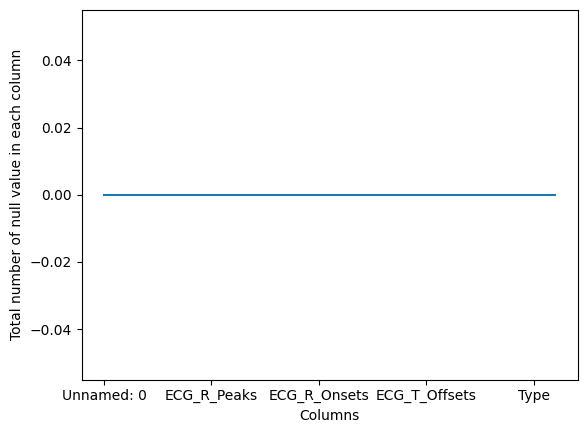

In [127]:
pd.isnull(df).sum().plot()
plt.xlabel('Columns')
plt.ylabel('Total number of null value in each column')

In [128]:
df['Type']=df['Type'].str.lower()
typenames=set(df['Type'])
print(sorted(typenames))

[' ventricular couplet', 'aberrated apcs', 'aberrated atrial couplet', 'aberrated beat', 'accelerated idioventricular rhythm', 'accelerated junctional rhythm', 'apc', 'atrial bigeminy', 'atrial couplet', 'atrial couplets', 'atrial escape beat', 'atrial fibrillation', 'atrial flutter', 'bidirectional ventricular tachycardia', 'bradycardia', 'conversion pause', 'end of atrial flutter', 'end of ventricular tachycardia', 'first degree avb', 'fusion pvc', 'fusion pvc/pvc couplet', 'fusion pvcs', 'interpolated pvc', 'junctional escape beat', 'junctional escape beats', 'junctional tachycardia', 'multiform pvcs', 'noise in lower signal', 'normal sinus rhythm', 'onset of 2:1 heart block', 'paroxysmal atrial flutter', 'pause', 'pauses', 'pvc', 'pvcs', 'pvcs/fusion pvc couplet', 'right bundle branch block', 'sinus arrhythmia', 'sinus bradycardia', 'supraventricular tachyarrhythmia', 'svta', 'tape slippage', 'ventricular bigeminy', 'ventricular couplet', 'ventricular couplets', 'ventricular escape

In [129]:
#remove tape slippage and "end of x"
df=df[df['Type']!='tape slippage']
df=df[df['Type']!='end of ventricular tachycardia']
df=df[df['Type']!='end of atrial flutter']
df=df[df['Type']!='noise in lower signal']


In [130]:
df['Type'] = df['Type'].replace('atrial couplets', 'atrial couplet')
df['Type'] = df['Type'].replace(' ventricular couplet', 'ventricular couplet')
df['Type'] = df['Type'].replace('pvcs', 'pvc')
df['Type'] = df['Type'].replace('ventricular couplets', 'ventricular couplet')
df['Type'] = df['Type'].replace('pvcs/fusion pvc couplet', 'pvc')
df['Type'] = df['Type'].replace('fusion pvc/pvc couplet', 'fusion pvc')
df['Type'] = df['Type'].replace('pauses', 'pause')
df['Type'] = df['Type'].replace('junctional escape beats', 'junctional escape beat')

In [131]:
df['Type']=df['Type'].str.lower()
typenames=set(df['Type'])
print(sorted(typenames))

['aberrated apcs', 'aberrated atrial couplet', 'aberrated beat', 'accelerated idioventricular rhythm', 'accelerated junctional rhythm', 'apc', 'atrial bigeminy', 'atrial couplet', 'atrial escape beat', 'atrial fibrillation', 'atrial flutter', 'bidirectional ventricular tachycardia', 'bradycardia', 'conversion pause', 'first degree avb', 'fusion pvc', 'fusion pvcs', 'interpolated pvc', 'junctional escape beat', 'junctional tachycardia', 'multiform pvcs', 'normal sinus rhythm', 'onset of 2:1 heart block', 'paroxysmal atrial flutter', 'pause', 'pvc', 'right bundle branch block', 'sinus arrhythmia', 'sinus bradycardia', 'supraventricular tachyarrhythmia', 'svta', 'ventricular bigeminy', 'ventricular couplet', 'ventricular escape beat', 'ventricular flutter', 'ventricular tachycardia', 'ventricular trigeminy', 'ventricular triplet', 'wpw']


In [132]:
typecounts=df['Type'].value_counts()
print(typecounts)

Type
pvc                                      68
apc                                      37
ventricular couplet                      35
ventricular tachycardia                  28
atrial fibrillation                      17
normal sinus rhythm                      15
ventricular bigeminy                     12
svta                                     10
sinus arrhythmia                          8
atrial couplet                            8
fusion pvc                                6
ventricular flutter                       6
pause                                     4
accelerated idioventricular rhythm        4
ventricular trigeminy                     4
aberrated atrial couplet                  3
ventricular triplet                       3
paroxysmal atrial flutter                 2
interpolated pvc                          2
first degree avb                          2
right bundle branch block                 2
fusion pvcs                               2
junctional escape beat     

In [133]:
fig = plt.figure(figsize=(10, 7))
plt.pie(typecounts, labels=typenames)
plt.show()

In [134]:
newdf=df.copy()

In [135]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
newdf['Type'] = label_encoder.fit_transform(newdf['Type'])

In [136]:
newdf.head()

Unnamed: 0   ECG_Raw  ECG_Clean   ECG_Rate  ECG_Quality  ECG_R_Peaks  \
0           0 -0.380306   0.001428  74.468633     0.946101     0.003704   
1           1 -0.281306   0.001781  78.415655     0.949031     0.003704   
2           2 -0.268685   0.004873  74.801518     0.957319     0.003704   
3           3 -0.319634  -0.002300  75.545953     0.966639     0.003704   
4           4 -0.326352   0.001130  78.632732     0.893220     0.003704   

   ECG_P_Peaks  ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ...  ECG_S_Peaks  \
0     0.003704      0.003704       0.003704     0.003704  ...     0.002778   
1     0.003704      0.003704       0.003704     0.003704  ...     0.002778   
2     0.003704      0.003704       0.003704     0.003704  ...     0.003704   
3     0.002778      0.002778       0.002778     0.003704  ...     0.003704   
4     0.003704      0.003704       0.003704     0.003704  ...     0.003704   

   ECG_T_Peaks  ECG_T_Onsets  ECG_T_Offsets  ECG_Phase_Atrial  \
0     0.003704      0.003704       0.003704          0.232407   
1     0.003704      0.003704       0.004630          0.199074   
2     0.002778      0.002778       0.002778          0.229630   
3     0.003704      0.003704       0.003704          0.204630   
4     0.002778      0.002778       0.002778          0.214815   

   ECG_Phase_Completion_Atrial  ECG_Phase_Ventricular  \
0                     0.500201               0.205556   
1                     0.506068               0.172222   
2                     0.518040               0.195370   
3                     0.485920               0.201852   
4                     0.500893               0.400000   

   ECG_Phase_Completion_Ventricular  Type        Participant  
0                          0.502619    25  MIT-Arrhythmia_00  
1                          0.498562    21  MIT-Arrhythmia_00  
2                          0.513093    25  MIT-Arrhythmia_00  
3                          0.484401     5  MIT-Arrhythmia_00  
4                          0.492209    21  MIT-Arrhythmia_00  

[5 rows x 22 columns]

<Axes: >

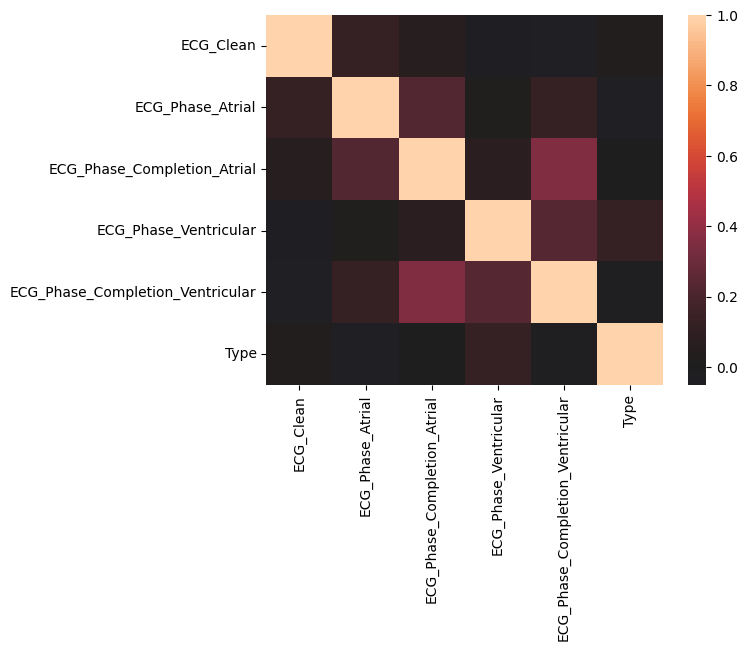

In [137]:
sns.heatmap(newdf[['ECG_Clean','ECG_Phase_Atrial','ECG_Phase_Completion_Atrial','ECG_Phase_Ventricular','ECG_Phase_Completion_Ventricular','Type']].corr(),center=0)

In [138]:
sns.heatmap(newdf[['ECG_Rate','ECG_Quality','ECG_R_Peaks','ECG_P_Peaks','ECG_P_Onsets','ECG_P_Offsets','Type']].corr(),center=0)

<Axes: >

<Axes: >

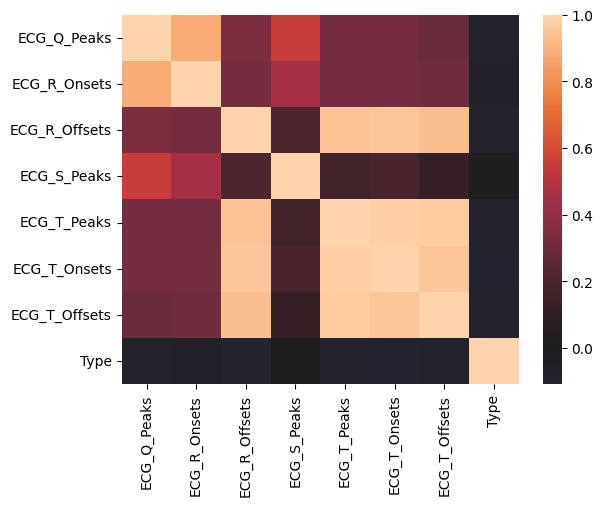

In [139]:
sns.heatmap(newdf[['ECG_Q_Peaks','ECG_R_Onsets','ECG_R_Offsets','ECG_S_Peaks','ECG_T_Peaks','ECG_T_Onsets','ECG_T_Offsets','Type']].corr(),center=0)

In [140]:
g=sns.PairGrid(newdf,vars=['ECG_Clean','ECG_Phase_Atrial','ECG_Phase_Completion_Atrial','ECG_Phase_Ventricular','ECG_Phase_Completion_Ventricular','Type'],hue='Type')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

In [141]:
newdf.head()

Unnamed: 0   ECG_Raw  ECG_Clean   ECG_Rate  ECG_Quality  ECG_R_Peaks  \
0           0 -0.380306   0.001428  74.468633     0.946101     0.003704   
1           1 -0.281306   0.001781  78.415655     0.949031     0.003704   
2           2 -0.268685   0.004873  74.801518     0.957319     0.003704   
3           3 -0.319634  -0.002300  75.545953     0.966639     0.003704   
4           4 -0.326352   0.001130  78.632732     0.893220     0.003704   

   ECG_P_Peaks  ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ...  ECG_S_Peaks  \
0     0.003704      0.003704       0.003704     0.003704  ...     0.002778   
1     0.003704      0.003704       0.003704     0.003704  ...     0.002778   
2     0.003704      0.003704       0.003704     0.003704  ...     0.003704   
3     0.002778      0.002778       0.002778     0.003704  ...     0.003704   
4     0.003704      0.003704       0.003704     0.003704  ...     0.003704   

   ECG_T_Peaks  ECG_T_Onsets  ECG_T_Offsets  ECG_Phase_Atrial  \
0     0.003704      0.003704       0.003704          0.232407   
1     0.003704      0.003704       0.004630          0.199074   
2     0.002778      0.002778       0.002778          0.229630   
3     0.003704      0.003704       0.003704          0.204630   
4     0.002778      0.002778       0.002778          0.214815   

   ECG_Phase_Completion_Atrial  ECG_Phase_Ventricular  \
0                     0.500201               0.205556   
1                     0.506068               0.172222   
2                     0.518040               0.195370   
3                     0.485920               0.201852   
4                     0.500893               0.400000   

   ECG_Phase_Completion_Ventricular  Type        Participant  
0                          0.502619    25  MIT-Arrhythmia_00  
1                          0.498562    21  MIT-Arrhythmia_00  
2                          0.513093    25  MIT-Arrhythmia_00  
3                          0.484401     5  MIT-Arrhythmia_00  
4                          0.492209    21  MIT-Arrhythmia_00  

[5 rows x 22 columns]

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [143]:

y=newdf.pop('Type')
newdf.pop('Participant')
X=newdf

In [144]:
print('x',X.info())
print('y',y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 303
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        300 non-null    int64  
 1   ECG_Raw                           300 non-null    float64
 2   ECG_Clean                         300 non-null    float64
 3   ECG_Rate                          300 non-null    float64
 4   ECG_Quality                       300 non-null    float64
 5   ECG_R_Peaks                       300 non-null    float64
 6   ECG_P_Peaks                       300 non-null    float64
 7   ECG_P_Onsets                      300 non-null    float64
 8   ECG_P_Offsets                     300 non-null    float64
 9   ECG_Q_Peaks                       300 non-null    float64
 10  ECG_R_Onsets                      300 non-null    float64
 11  ECG_R_Offsets                     300 non-null    float64
 12  ECG_S_Peaks  

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 234 to 102
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        240 non-null    int64  
 1   ECG_Raw                           240 non-null    float64
 2   ECG_Clean                         240 non-null    float64
 3   ECG_Rate                          240 non-null    float64
 4   ECG_Quality                       240 non-null    float64
 5   ECG_R_Peaks                       240 non-null    float64
 6   ECG_P_Peaks                       240 non-null    float64
 7   ECG_P_Onsets                      240 non-null    float64
 8   ECG_P_Offsets                     240 non-null    float64
 9   ECG_Q_Peaks                       240 non-null    float64
 10  ECG_R_Onsets                      240 non-null    float64
 11  ECG_R_Offsets                     240 non-null    float64
 12  ECG_S_Peaks

In [147]:
print(y_train.info())
print(y_test.info())

<class 'pandas.core.series.Series'>
Index: 240 entries, 234 to 102
Series name: Type
Non-Null Count  Dtype
--------------  -----
240 non-null    int32
dtypes: int32(1)
memory usage: 2.8 KB
None
<class 'pandas.core.series.Series'>
Index: 60 entries, 203 to 25
Series name: Type
Non-Null Count  Dtype
--------------  -----
60 non-null     int32
dtypes: int32(1)
memory usage: 720.0 bytes
None


In [148]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [149]:
predictions = knn.predict(X_test)

In [150]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.18333333333333332


In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [152]:
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 137.03096900655706
R-squared: -0.11644296479338578


In [153]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [154]:
# Initialize the SVM classifier
svm = SVC(kernel='linear')

# Train the classifier
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,zero_division=1))

Accuracy: 0.23333333333333334

Classification Report:
              precision    recall  f1-score   support

           2       1.00      0.00      0.00         1
           3       1.00      0.00      0.00         1
           5       1.00      0.00      0.00         9
           7       0.00      0.00      0.00         3
           9       1.00      0.00      0.00         2
          13       1.00      0.00      0.00         1
          15       1.00      0.00      0.00         2
          19       1.00      0.00      0.00         1
          21       1.00      0.00      0.00         2
          22       0.00      1.00      0.00         0
          23       1.00      0.00      0.00         2
          24       0.50      1.00      0.67         1
          25       0.27      0.77      0.40        13
          30       1.00      0.00      0.00         5
          31       1.00      0.00      0.00         1
          32       0.17      0.43      0.24         7
          34       1.00    

In [155]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

In [156]:
svm = LinearSVC(class_weight='balanced', dual= False)

# Train the classifier
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Set zero_division parameter to 1

Accuracy: 0.05

Classification Report:
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      1.00      0.00         0
           5       1.00      0.00      0.00         9
           6       0.00      1.00      0.00         0
           7       0.33      0.33      0.33         3
           8       0.00      1.00      0.00         0
           9       1.00      0.00      0.00         2
          10       0.00      1.00      0.00         0
          11       0.00      1.00      0.00         0
          12       0.00      1.00      0.00         0
          13       0.00      0.00      0.00         1
          14       0.00      1.00      0.00         0
          15       0.00      0.00      0.00         2
          16       0.00      1.00      0.00         0
          17       0.00      1.00      0.0

In [157]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [158]:
svm = SVC(kernel='rbf', class_weight='balanced')

# Train the classifier
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,zero_division =1))

Accuracy: 0.03333333333333333

Classification Report:
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           2       0.00      0.00      0.00         1
           3       1.00      0.00      0.00         1
           4       0.00      1.00      0.00         0
           5       1.00      0.00      0.00         9
           6       0.00      1.00      0.00         0
           7       1.00      0.00      0.00         3
           9       1.00      0.00      0.00         2
          11       0.00      1.00      0.00         0
          13       0.10      1.00      0.18         1
          15       1.00      0.00      0.00         2
          18       0.00      1.00      0.00         0
          19       1.00      0.00      0.00         1
          20       0.00      1.00      0.00         0
          21       1.00      0.00      0.00         2
          22       0.00      1.00      0.00         0
          23       1.00    

In [159]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

In [160]:
gb_clf = GradientBoostingClassifier()

# Train the classifier
gb_clf.fit(X_train, y_train)

# Make predictions
y_pred = gb_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.21666666666666667


In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [162]:
rf_clf = RandomForestClassifier()

# Train the classifier
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,zero_division=1))

Accuracy: 0.16666666666666666

Classification Report:
              precision    recall  f1-score   support

           2       1.00      0.00      0.00         1
           3       1.00      0.00      0.00         1
           5       0.40      0.22      0.29         9
           7       1.00      0.00      0.00         3
           9       1.00      0.00      0.00         2
          13       1.00      0.00      0.00         1
          15       1.00      0.00      0.00         2
          19       1.00      0.00      0.00         1
          21       1.00      0.50      0.67         2
          23       1.00      0.00      0.00         2
          24       1.00      0.00      0.00         1
          25       0.15      0.31      0.20        13
          27       0.00      1.00      0.00         0
          30       1.00      0.00      0.00         5
          31       0.00      0.00      0.00         1
          32       0.14      0.29      0.19         7
          34       1.00    

In [44]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

In [45]:
pca = PCA(n_components=10)  # Specify the number of components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier()

# Train the classifier on PCA-transformed data
rf_clf.fit(X_train_pca, y_train)

# Make predictions on the PCA-transformed testing data
y_pred = rf_clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (after PCA):", accuracy)

# Print classification report

print("\nClassification Report (after PCA):")
print(classification_report(y_test, y_pred, zero_division=1))

Accuracy (after PCA): 0.1

Classification Report (after PCA):
              precision    recall  f1-score   support

           1       0.00      1.00      0.00         0
           2       1.00      0.00      0.00         1
           3       1.00      0.00      0.00         1
           5       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         2
          13       1.00      0.00      0.00         1
          15       1.00      0.00      0.00         2
          19       1.00      0.00      0.00         1
          21       0.33      0.50      0.40         2
          23       1.00      0.00      0.00         2
          24       1.00      0.00      0.00         1
          25       0.15      0.31      0.21        13
          30       1.00      0.00      0.00         5
          31       0.00      0.00      0.00         1
          32       0.00      0.00      0.00         7
          34       

In [46]:
pca = PCA(n_components=10)  # Specify the number of components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

models = {
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Linear Support Vector Classifier (LinearSVC)": LinearSVC(),
    "Support Vector Classifier (SVC)": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Random Forest Classifier": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred,zero_division=1)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    print("\n")

Model: K-Nearest Neighbors (KNN)
Accuracy: 0.18333333333333332
Classification Report:
              precision    recall  f1-score   support

           1       0.00      1.00      0.00         0
           2       1.00      0.00      0.00         1
           3       0.33      1.00      0.50         1
           5       0.33      0.44      0.38         9
           6       0.00      1.00      0.00         0
           7       0.25      0.33      0.29         3
           9       0.00      0.00      0.00         2
          11       0.00      1.00      0.00         0
          13       1.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          19       1.00      0.00      0.00         1
          21       0.00      0.00      0.00         2
          23       1.00      0.00      0.00         2
          24       1.00      1.00      1.00         1
          25       0.19      0.23      0.21        13
          30       1.00      0.00      0.00      

C:\Users\forer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\forer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model: Linear Support Vector Classifier (LinearSVC)
Accuracy: 0.16666666666666666
Classification Report:
              precision    recall  f1-score   support

           2       1.00      0.00      0.00         1
           3       1.00      0.00      0.00         1
           5       0.00      0.00      0.00         9
           7       1.00      0.00      0.00         3
           9       1.00      0.00      0.00         2
          10       0.00      1.00      0.00         0
          13       1.00      0.00      0.00         1
          15       1.00      0.00      0.00         2
          19       1.00      0.00      0.00         1
          21       0.00      0.00      0.00         2
          23       1.00      0.00      0.00         2
          24       1.00      0.00      0.00         1
          25       0.32      0.69      0.44        13
          30       1.00      0.00      0.00         5
          31       1.00      0.00      0.00         1
          32       1.00      0

In [47]:
from sklearn.manifold import TSNE

In [48]:
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)

# Initialize and train models
models = {
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Linear Support Vector Classifier (LinearSVC)": LinearSVC(),
    "Support Vector Classifier (SVC)": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Random Forest Classifier": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train_tsne, y_train)
    y_pred = model.predict(X_test_tsne)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred,zero_division=1)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)
    print("\n")

Model: K-Nearest Neighbors (KNN)
Accuracy: 0.15
Classification Report:
              precision    recall  f1-score   support

           1       0.00      1.00      0.00         0
           2       0.00      0.00      0.00         1
           3       1.00      0.00      0.00         1
           5       0.20      0.11      0.14         9
           7       1.00      0.00      0.00         3
           9       1.00      0.00      0.00         2
          13       1.00      0.00      0.00         1
          15       1.00      0.00      0.00         2
          19       1.00      0.00      0.00         1
          21       0.00      0.00      0.00         2
          23       1.00      0.00      0.00         2
          24       1.00      0.00      0.00         1
          25       1.00      0.00      0.00        13
          30       1.00      0.00      0.00         5
          31       1.00      0.00      0.00         1
          32       0.19      0.57      0.29         7
          

C:\Users\forer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\forer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model: Gradient Boosting Classifier
Accuracy: 0.1
Classification Report:
              precision    recall  f1-score   support

           1       0.00      1.00      0.00         0
           2       0.00      0.00      0.00         1
           3       1.00      0.00      0.00         1
           5       0.27      0.44      0.33         9
           7       1.00      0.00      0.00         3
           9       1.00      0.00      0.00         2
          13       1.00      0.00      0.00         1
          15       1.00      0.00      0.00         2
          16       0.00      1.00      0.00         0
          19       1.00      0.00      0.00         1
          21       0.00      0.00      0.00         2
          23       1.00      0.00      0.00         2
          24       1.00      0.00      0.00         1
          25       1.00      0.00      0.00        13
          30       0.00      0.00      0.00         5
          31       0.00      0.00      0.00         1
        

In [49]:
from sklearn.tree import DecisionTreeClassifier

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=100000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Classifier": SVC(max_iter=5000)
}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print the accuracy
    print(f"{name}: Accuracy = {accuracy:.4f}")


Logistic Regression: Accuracy = 0.2667
Decision Tree: Accuracy = 0.1000
Random Forest: Accuracy = 0.2167
Support Vector Classifier: Accuracy = 0.1667


C:\Users\forer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [94]:
rf_clf = RandomForestClassifier(n_estimators=500, criterion='gini',n_jobs=-1)

# Train the classifier
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,zero_division=1))

Accuracy: 0.13333333333333333

Classification Report:
              precision    recall  f1-score   support

           2       1.00      0.00      0.00         1
           3       1.00      0.00      0.00         1
           5       0.00      0.00      0.00         9
           7       1.00      0.00      0.00         3
           9       1.00      0.00      0.00         2
          13       1.00      0.00      0.00         1
          15       1.00      0.00      0.00         2
          19       1.00      0.00      0.00         1
          21       0.00      0.00      0.00         2
          23       1.00      0.00      0.00         2
          24       1.00      1.00      1.00         1
          25       0.17      0.38      0.23        13
          30       1.00      0.20      0.33         5
          31       0.00      0.00      0.00         1
          32       0.10      0.14      0.12         7
          34       1.00      0.00      0.00         1
          35       0.00    

In [95]:
from sklearn.ensemble import AdaBoostClassifier
ada= AdaBoostClassifier(estimator=rf_clf, learning_rate=0.9)

In [96]:
ada.fit(X_train, y_train)

C:\Users\forer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=RandomForestClassifier(n_estimators=500,
                                                    n_jobs=-1),
                   learning_rate=0.9)

In [97]:
y_pred=ada.predict(X_test)
accuracy= accuracy_score(y_test, y_pred)
print(accuracy*100)

15.0


- since, we can't use normal machine learning algorithms here,
- we can change the dataset 

In [98]:
df= pd.read_csv('heart_2020_cleaned.csv')

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [100]:
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [101]:
from sklearn.preprocessing import LabelEncoder

data1=df.copy()
le = LabelEncoder()
le.fit(data1['HeartDisease'])
data1['HeartDisease']=le.transform(data1['HeartDisease'])

le.fit(data1['Smoking'])
data1['Smoking']=le.transform(data1['Smoking'])

le.fit(data1['AlcoholDrinking'])
data1['AlcoholDrinking']=le.transform(data1['AlcoholDrinking'])

le.fit(data1['Stroke'])
data1['Stroke']=le.transform(data1['Stroke'])

le.fit(data1['DiffWalking'])
data1['DiffWalking']=le.transform(data1['DiffWalking'])

le.fit(data1['Sex'])
data1['Sex']=le.transform(data1['Sex'])

le.fit(data1['AgeCategory'])
data1['AgeCategory']=le.transform(data1['AgeCategory'])

le.fit(data1['Race'])
data1['Race']=le.transform(data1['Race'])

le.fit(data1['Diabetic'])
data1['Diabetic']=le.transform(data1['Diabetic'])


le.fit(data1['PhysicalActivity'])
data1['PhysicalActivity']=le.transform(data1['PhysicalActivity'])

le.fit(data1['GenHealth'])
data1['GenHealth']=le.transform(data1['GenHealth'])

le.fit(data1['Asthma'])
data1['Asthma']=le.transform(data1['Asthma'])

le.fit(data1['KidneyDisease'])
data1['KidneyDisease']=le.transform(data1['KidneyDisease'])

le.fit(data1['SkinCancer'])
data1['SkinCancer']=le.transform(data1['SkinCancer'])

In [102]:
plt.figure(figsize = (15,10))
sns.heatmap(data1.corr(),annot = True,cmap='Reds')

<Axes: >

In [103]:
from sklearn.model_selection import train_test_split
x = data1.drop(["HeartDisease"] , axis = 1).values
y = data1["HeartDisease"].values


In [104]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [106]:
std_scaler = StandardScaler()
x_train_1 = std_scaler.fit_transform(x_train)
x_test_1 = std_scaler.fit_transform(x_test)

In [107]:
x_train_1[0:5]

array([[-0.06924726,  1.19315428, -0.27096094, -0.19732593,  1.34016816,
         1.26949747, -0.40107788,  1.05179714,  0.41779766,  0.49797961,
        -0.41982847,  0.53784732,  1.15892019, -0.76371224, -0.39369244,
        -0.19548267, -0.32053117],
       [-0.53145812,  1.19315428, -0.27096094, -0.19732593, -0.42359834,
         1.39517476, -0.40107788,  1.05179714, -0.70443026,  0.49797961,
        -0.41982847,  0.53784732, -1.44715214, -0.06695754, -0.39369244,
        -0.19548267, -0.32053117],
       [-0.54089099, -0.83811458, -0.27096094, -0.19732593, -0.42359834,
         0.01272461, -0.40107788, -0.95075368,  0.69835464,  0.49797961,
        -0.41982847,  0.53784732,  1.15892019, -0.06695754, -0.39369244,
        -0.19548267, -0.32053117],
       [-1.07070411, -0.83811458, -0.27096094, -0.19732593, -0.42359834,
        -0.48998453, -0.40107788, -0.95075368, -0.1433163 ,  0.49797961,
        -0.41982847,  0.53784732, -1.44715214,  0.62979715, -0.39369244,
        -0.19548267

In [108]:
from sklearn.ensemble import RandomForestClassifier
rcf=RandomForestClassifier(n_estimators=500, criterion='entropy',n_jobs=-1)
rcf.fit(x_train_1,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=500, n_jobs=-1)

In [109]:
y_pred=rcf.predict(x_test)

In [110]:
accuracy_score(y_test, y_pred)*100

91.31321217276013

In [113]:
pca = PCA(n_components=10)  # Specify the number of components
x_train_pca = pca.fit_transform(x_train_1)
x_test_pca = pca.transform(x_test)

In [115]:
from sklearn.ensemble import RandomForestClassifier
rcf=RandomForestClassifier(n_estimators=500, criterion='entropy',n_jobs=-1)
rcf.fit(x_train_pca,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=500, n_jobs=-1)

In [118]:
y_pred=rcf.predict(x_test_pca)

In [119]:
accuracy_score(y_test, y_pred)*100

91.31321217276013